In [1]:
# import required libraries
import numpy as np
import codecs, json
import matplotlib.pyplot as plt
import math
import scipy
from scipy import linalg
from scipy import stats

# import py file
import ps1_functions as ps1

# 3.1 Understanding the Data Set

Use the provided function read json files() to read the two JSON files containing the data, swiss roll points.json and swiss roll labels.json. The swiss roll points.json contains 2000 points, each with 3 features and
swiss roll labels.json contains labels for each of the 2000 points, ranging from 0 to 1. Pre-process the
data by centering it (i.e. data points have zero mean). Next, visualize this data set using a scatter plot
where the provided features are x, y, and z coordinates and each point is colored by its label.

In [2]:
# load data
swissPoints = ps1.load_json_files("data/swiss_roll_points.json")
swissLabels = ps1.load_json_files("data/swiss_roll_labels.json")

In [3]:
# preprocess the data by centering it
swissPoints_centered = swissPoints - np.mean(swissPoints)
swissLabels_centered = swissLabels - np.mean(swissLabels)

In [4]:
# define x, y, and z by extracting coordinates from each array

x = [i[0] for i in swissPoints_centered]
y = [i[1] for i in swissPoints_centered]
z = [i[2] for i in swissPoints_centered]

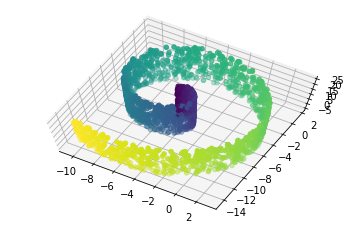

In [5]:
# plot the 3-d scatter plot

# 3-D spiral graph in matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x, y, z, c = swissLabels_centered)
ax.view_init(elev = 75)

## Question 3.1.1. 

What does this visualization of the swiss roll data set look like? What properties do you notice about the data set? Are the provided labels meaningful, and if so, in what way? How do you expect a “good” dimensionality reduction technique to look for the swiss roll data set?

### Answer
From looking at the swiss roll dataset, it seems like there is clustering along a manifold, and the provided labels are useful. We can clearly see that, without plotting the data, there doesn't seem to be a linear relationship between the points. However, if we plot the points we see a clear manifold, along which the points are situated. The labels are meaningful in that we can see clear groupings of similar points, and the similarities in color reinforce the similarity in distance that we observe in the manifold. 

# 3.2 Visualizing Data with PCA
Now that we have an understanding of the swiss roll data set and how we expect a successful dimensionality reduction to look, it’s time to experiment. We’ll start with PCA.

1. Run PCA on the swiss roll data set, obtaining the principal components, projections, and singular values
2. Plot the swiss roll in two dimensions, using the principal components. You might wish to try different combinations, since there are few of them (i.e. the first and second components, the first and third components, the second and third components). Color the points with their corresponding labels.
3. Plot the singular values in whatever way you see fit. This could be a plot of the singular values themselves, or the cumulative sum, which would correspond to the “explained variance”.

In [6]:
# Define a function to calculate the PCA

def calculatePCA(matrix):
    '''
    Performs PCA on matrix

    Inputs:
        High-dimensional matrix

    Outputs:
        1. Principal components
        2. New matrix, projected on to new space of principal components
        3. Singular values

    '''

    # standardize matrix by subtracting mean and dividing by standard deviation
    standardMatrix = (matrix - np.mean(matrix, axis = 0)) / np.std(matrix)
    
    # calculate svd of matrix
    U, S, VT = np.linalg.svd(standardMatrix)
    
    # Here, VT is the matrix where each of the rows are principal components
    # The product of the matrix multiplication of the standardized matrix with the principal components = projection
    # Here, S is the singular values of the matrix
    
    # (1) Get the principal components
    principalComponents = VT
    
    # (2) Get the projection
    projection = np.matmul(standardMatrix, np.ndarray.transpose(principalComponents))
    
    # (3) Get the singular values
    singularValues = S
    
    # return the matrix
    return principalComponents, projection, singularValues

In [7]:
# 1. Run PCA on the swiss roll data set, obtaining the principal components, projections, and singular values

principalComponents, projection, singularValues = calculatePCA(swissPoints_centered)

In [8]:
# 2. Plot the swiss roll in two dimensions, using the principal components. You might wish 
# to try different combinations, since there are few of them (i.e. the first and second components, 
# the first and third components, the second and third components). Color the points with their corresponding labels.

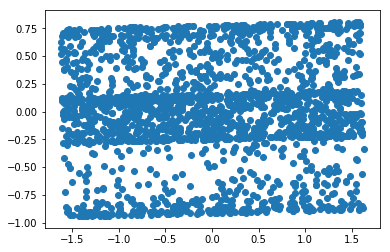

In [9]:
# First and second component:
plt.scatter(x = projection[:, 0], y = projection[:, 1])
#plt.show()
plt.savefig("figures/3.2_pca1_firstSecondComponents.png")

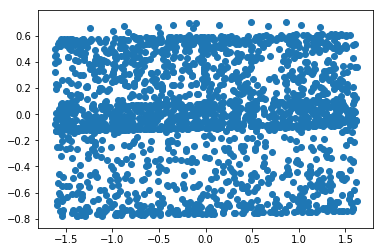

In [10]:
# First and third component:
plt.scatter(x = projection[:, 0], y = projection[:, 2])
#plt.show()
plt.savefig("figures/3.2_pca1_firstThirdComponents.png")

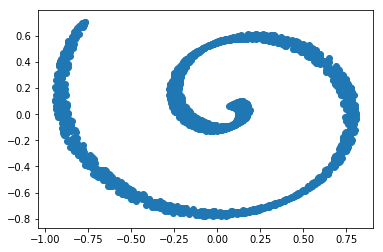

In [11]:
# Second and third component:
p3 = plt.scatter(x = projection[:, 1], y = projection[:, 2])
#plt.show()
plt.savefig("figures/3.2_pca1_secondThirdComponents.png")

#### 3. Plot the singular values in whatever way you see fit. This could be a plot of the singular values themselves, or the cumulative sum, which would correspond to the “explained variance”.

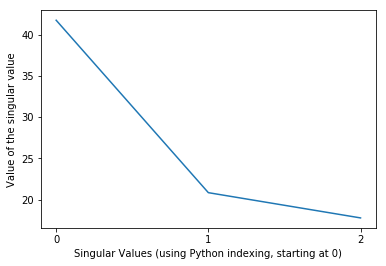

In [12]:
plt.plot(singularValues)
plt.xticks([0, 1, 2])
plt.xlabel("Singular Values (using Python indexing, starting at 0)")
plt.ylabel("Value of the singular value")
plt.savefig("figures/3.2_pca1_singularValues.png")

## Question 3.2.1.

As a dimensionality reduction technique, to what extent does PCA retain properties of the swiss roll data set? Can you explain why the visualizations look like this, given how the algorithm works? What can you learn about the intrinsic dimensionality from the singular values?

## Answer: 

In this case, PCA seems to uncover the different aspects of the swiss roll shape. Visualizing the 2-D representations of the principal components is akin to taking slices of the swiss roll and looking at the resulting visualization. 

Given how the algorithm works, I can see why these specific visualizations took place. One way to imagine it is that each of the principal components represented a new mapping of the X values. So, multiplying X by the principal components created a new mapping of the X values. But, the directionality of the Xs was nonlinear (a roll in this sense), so if we had to pick linear bases for each principal component, the linear bases will end up being similar to the original axes (since there is no linear means for accounting for the shape of the plot). 

If the goal of PCA is to map the data in the direction of greatest variability, then no arbitrary direction will be an improvement over the original axes against which the data was mapped, simply because explaining any extra variability in the data would involve somehow accounting for the "swirilng" behavior observed with the 3-D plot, which clearly would not be possible with a linear plot. 

We also notice that the singular values are all noticeably non-zero. This indicates that each of the underlying dimensions originally present in the data is necessary to represent the data as a whole (i.e., you wouldn't be able to represent this data from just using 2 of the 3 dimensions). 


# 3.3 Visualizing Data with Diffusion Maps

Now we will look at diffusion maps as a dimensionality reduction technique. Recall that for each point x in our data set, Ψt(x) is an n-dimensional vector 4 so when we visualize it, we can only visualize two or three dimensional slices. Your tasks will be to:

1. Construct the diffusion map Ψt of the swiss roll data set using euclidean distance, Gaussian kernel with width σ = 3.0, and diffusion parameter t = 1.
2. Create two-dimensional scatter plots of the diffusion mapping using different coordinates.
3. Plot the eigenvalues λi of the Markov matrix M
4. Repeat for σ=1.0 and σ=6.0


The steps of the diffusion maps algorithm are:

1. Define a kernel and create a kernel matrix K such that Kij = k(Xi, Xj)
2. Create the diffusion matrix by normalizing the rows of the diffusion matrix
3. Calculate the eigenvectors of the diffusion matrix
4. Map to the d-dimensional diffusion space at time t, using the d-dominant eigenvectors and eigenvalues

### 1. Construct the diffusion map Ψt of the swiss roll data set using euclidean distance, Gaussian kernel with width σ = 3.0, and diffusion parameter t = 1.

In [13]:
# Get distance matrix
D = ps1.compute_distances(swissPoints_centered)

In [14]:
# Compute affinity matrix
W = ps1.compute_affinity_matrix(D, "gaussian", 3, None)

In [15]:
# Get eigenvectors and eigenvalues for diffusion map
#diff_vec, diff_eig = ps1.diff_map_info(W)
diff_vec, diff_eig = ps1.diff_map_info(W)

In [16]:
# Get diffusion map
diff_map = ps1.get_diff_map(diff_vec, diff_eig, 1)

### 2. Create two-dimensional scatter plots of the diffusion mapping using different coordinates.

##### Plot first and second coordinates

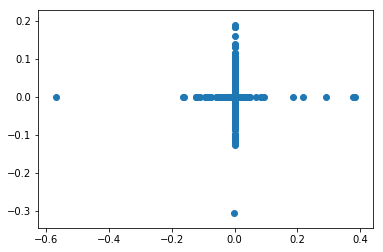

In [17]:
plt.scatter(diff_map[:, 0], diff_map[:, 1])
plt.savefig("figures/3.3.1_firstSecondComponents.png")

##### Plot second and third coordinates

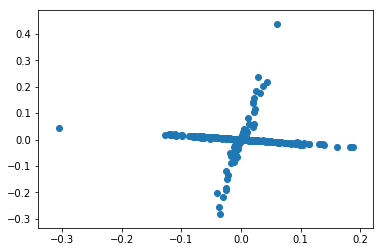

In [18]:
plt.scatter(diff_map[:, 1], diff_map[:, 2])
plt.savefig("figures/3.3.1_secondThirdComponents.png")

##### Plot third and fourth coordinates

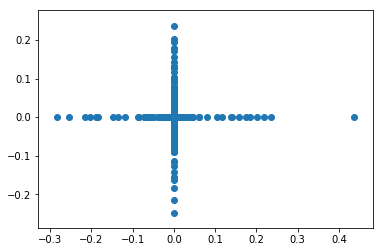

In [19]:
plt.scatter(diff_map[:, 2], diff_map[:, 3])
plt.savefig("figures/3.3.1_thirdFourthComponents.png")

##### Plot first and third coordinates

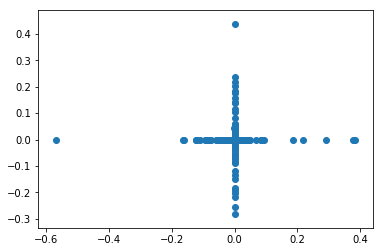

In [20]:
plt.scatter(diff_map[:, 0], diff_map[:, 2])
plt.savefig("figures/3.3.1_firstThirdComponents.png")

### 3. Plot the eigenvalues of the Markov matrix

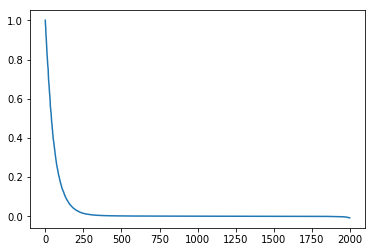

In [21]:
# plot the eigenvalues of the Markov matrix
plt.plot(diff_eig)
plt.savefig("figures/3.3.1_eigenvaluesMarkov.png")

### 4. Repeat for sigma = 1 and sigma = 6

##### For sigma = 1

In [22]:
# For sigma = 1

# same distance matrix as above

# Compute affinity matrix
W_2 = ps1.compute_affinity_matrix(D, "gaussian", 1)

# Get eigenvectors and eigenvalues for diffusion map
diff_vec_2, diff_eig_2 = ps1.diff_map_info(W_2)

# Get diffusion map
diff_map_2 = ps1.get_diff_map(diff_vec_2, diff_eig_2, 1)

#### Create two-dimensional scatter plots of the diffusion mapping using different coordinates.

##### For first and second coordinates

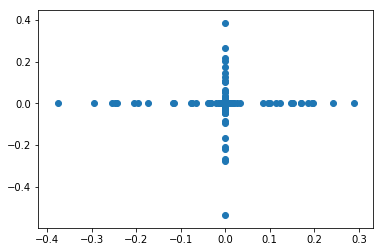

In [23]:
plt.scatter(diff_map_2[:, 0], diff_map_2[:, 1])
plt.savefig("figures/3.3.2_firstSecondComponents.png")

##### For second and third coordinates

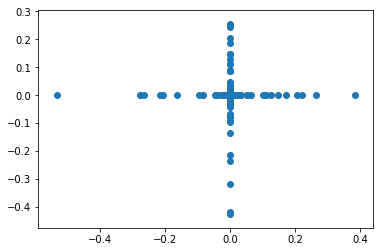

In [24]:
plt.scatter(diff_map_2[:, 1], diff_map_2[:, 2])
plt.savefig("figures/3.3.2_secondThirdComponents.png")

##### For third and fourth coordinates

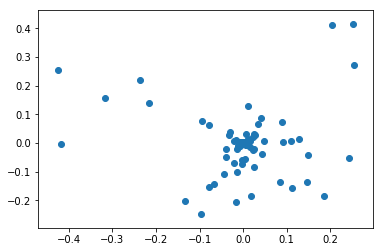

In [25]:
plt.scatter(diff_map_2[:, 2], diff_map_2[:, 3])
plt.savefig("figures/3.3.2_thirdFourthComponents.png")

##### Plot first and third coordinates

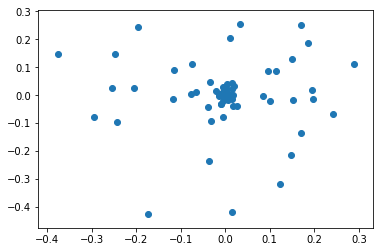

In [26]:
plt.scatter(diff_map_2[:, 0], diff_map_2[:, 2])
plt.savefig("figures/3.3.2_firstThirdComponents.png")

### Plot the eigenvalues of the Markov matrix

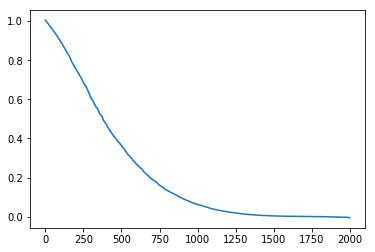

In [27]:
# plot the eigenvalues of the Markov matrix
plt.plot(diff_eig_2)
plt.savefig("figures/3.3.2_eigenvaluesMarkov.png")

##### For sigma = 6

In [28]:
# For sigma = 6

# same distance matrix as above

# Compute affinity matrix
W_3 = ps1.compute_affinity_matrix(D, "gaussian", 6)

# Get eigenvectors and eigenvalues for diffusion map
diff_vec_3, diff_eig_3 = ps1.diff_map_info(W_3)

# Get diffusion map
diff_map_3 = ps1.get_diff_map(diff_vec_3, diff_eig_3, 1)

### Create two-dimensional scatter plots of the diffusion mapping using different coordinates.

##### Plot first and second coordinates

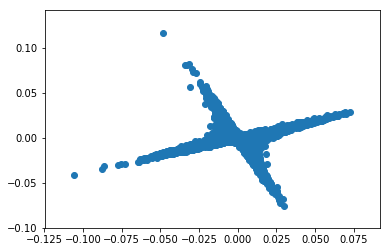

In [29]:
plt.scatter(diff_map_3[:, 0], diff_map_3[:, 1])
plt.savefig("figures/3.3.3_firstSecondComponents.png")

##### Plot second and third coordinates

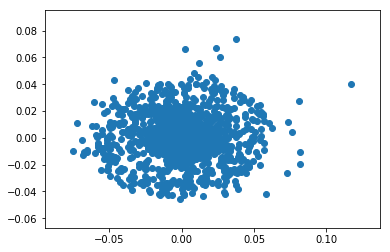

In [30]:
plt.scatter(diff_map_3[:, 1], diff_map_3[:, 2])
plt.savefig("figures/3.3.3_secondThirdComponents.png")

##### Plot third and fourth coordinates

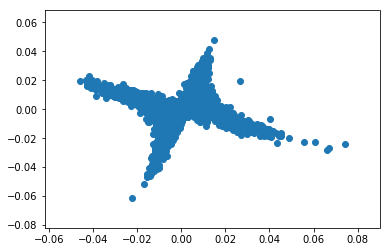

In [31]:
plt.scatter(diff_map_3[:, 2], diff_map_3[:, 3])
plt.savefig("figures/3.3.3_thirdFourthComponents.png")

##### Plot first and third coordinates

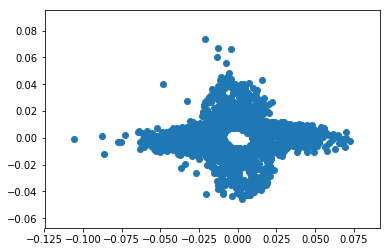

In [32]:
plt.scatter(diff_map_3[:, 0], diff_map_3[:, 2])
plt.savefig("figures/3.3.3_firstThirdComponents.png")

### Plot the eigenvalues of the Markov matrix

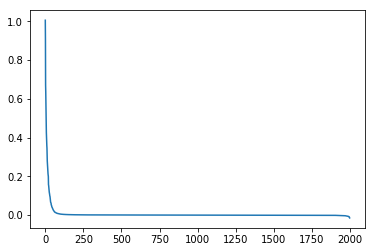

In [33]:
# plot the eigenvalues of the Markov matrix
plt.plot(diff_eig_3)
plt.savefig("figures/3.3.3_eigenvaluesMarkov.png")

## Question 3.3.1. 

As a dimensionality reduction technique, to what extent does diffusion mapping retain properties of the swiss roll data set? Can you explain why the visualizations look like this, given how the algorithm works? What can you learn about the intrinsic dimensionality of the data set from the eigenvalues of M? How does the choice of Gaussian kernel width σ change the embedding and why?

#### Answer

Diffusion mapping retains the original shape of the swiss roll. The visualizations look like this because the diffusion mapping essentially uncovers the principal components of the unfolded manifold. Therefore, this is why the 2-D plots appear different than those from PCA. On one end, the points do occupy clear points on the coordinates defined by the diffusion mapping. However, we can see that the mappings on the coordinates appear more like typical linear axes than the mappings from PCA, and this tells us that we were able to uncover the "linear" patterns in the data by unfolding the manifold and calculating the eigenvectors in the direction of the manifold.

From the eigenvalues of M, we can tell how many (nonlinear) dimensions are required to describe the manifold of M, which gives us the intrinsic dimensionality. The eigenvalues for which the values are close to zero are not required for describing the manifold of M, so by looking at the eigenvalues which are well above 0, we can see how many dimensions are required and thus uncover M's intrinsic dimensionality. 

The choice of Gaussian kernel width affected the values of the eigenvalues (derived from the Markov matrix). As sigma increased, the values of the eigenvectors tended towards zero much more quickly. This makes sense because the width determines the mapping of the "neighborhoods" around which the Gaussian kernel permits affinity. A larger sigma means that the affinity values will increase (because a larger neighborhood will be permitted to have significantly nonzero values). But, defining a larger neighborhood then means that the embeddings will display wider levels of clustering (e.g., the 2-D plots of sigma = 6 have wider clusters than the 2-D plots of sigma = 1 or sigma = 3), in contrast to points that, when mapped onto the diffusion coordinates, will line up close to a line. As neighborhood expands (due to the Gaussian kernel width increasing), the mappings become less specific and therefore wider clustering occurs as less similar observations are grouped together.

# 3.4 Understanding the First Eigenvector of the Markov Matrix

Now let’s see a curious property of the first left eigenvector of the Markov matrix. Your task will be to
1. Construct the affinity matrix of the swiss roll data set using euclidean distance and Gaussian kernel
with width σ = 1.0.
2. Compute the largest left eigenvector φ1 of M = D−1W, which may be obtained as φ1 = v1D1/2.
3. Plot the swiss roll in 3 dimensions using the original coordinates and color the points using the corre- sponding values in φ1.


### 1. Construct the affinity matrix of the swiss roll data set using euclidean distance and Gaussian kernel with width σ = 1.0.

In [34]:
# See above, W_2, for affinity matrix of swiss roll dataset with width = 1.0

### 2. Compute the largest left eigenvector φ1 of M = D−1W, which may be obtained as φ1 = v1D1/2.

In [35]:
# Taking it from the eigenvector matrix
largestLeftEigVec = diff_map_2[:, 0]

### 3. Plot the swiss roll in 3 dimensions using the original coordinates and color the points using the corresponding values in φ1.

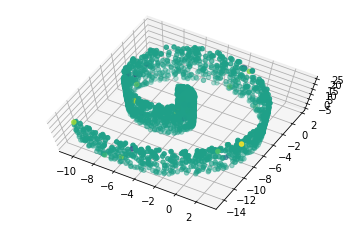

In [36]:
# plot the 3-d scatter plot

# 3-D spiral graph in matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x, y, z, c = largestLeftEigVec)
ax.view_init(elev = 75)
plt.savefig("figures/3.4_swissRoll.png")

## Question 3.4.1. How do the values in φ1 correspond to the structure of the swiss roll? Can you explain what you are seeing in terms of diffusion?

The values in the largest left eigenvector seem to explain the directionality and structure of the swiss roll (i.e., it moves in the direction of the swiss roll). In terms of diffusion, this means that the diffusion of the swiss roll follows the general direction of the largest left eigenvector. Because we unfold the manifold, the largest left eigenvector corresponds to the direction of the "unfolded sheet", so when you use this eigenvector and use it to color the original plot of the swiss roll in 3 dimensions, the eigenvector will track the direction of the manifold. 

# 3.5 Using an Adaptive Gaussian Kernel

We have seen the advantages of diffusion maps over PCA in the last portion of the experiment; however, the Gaussian kernel width σ was fixed for all data points. In this portion of Experiment 1, we’ll see the effect of using an adaptive Gaussian kernel. To this end, we will use an adaptive k-nearest neighbors kernel, defined in the following way. Let the k-nearest neighbors kernel κk-nn be given by

1􏰂 􏰂 ∥xi−xj∥2􏰃 􏰂 ∥xi−xj∥2􏰃􏰃 κk-nn(xi,xj)= 2 exp − 2σk(xi)2 +exp − 2σk(xj)2


where σk(x) is the distance from x to its kth nearest neighbor. Note that κk-nn satisfies the property of a kernel. Let σk-nn = {σ1, . . . , σn} denote these choices of adaptively chosen kernel parameters, for a fixed k. Now that we have defined this new adaptive kernel, let’s see how it performs differently that a fixed-width kernel. Your tasks for this portion of Experiment 1 are
1. Construct the diffusion map Ψt of the swiss roll data set using euclidean distance, adaptive k-nearest neighbor Gaussian kernel with k = 5, and diffusion parameter t = 1.
2. Create two-dimensional scatter plots of the diffusion mapping using different coordinates.
3. Plot the eigenvalues λi of the Markov matrix M
4. Repeat for k = 10

In [37]:
# 1. Construct the diffusion map Ψt of the swiss roll data set using euclidean distance, adaptive k-nearest neighbor 
# Gaussian kernel with k = 5, and diffusion parameter t = 1.

# create affinity matrix
W_adaptive_1 = ps1.compute_affinity_matrix(D, "adaptive", None, 5)

# Get eigenvectors and eigenvalues for diffusion map
diff_vec_adaptive_1, diff_eig_adaptive_1 = ps1.diff_map_info(W_adaptive_1)

# Get diffusion map
diff_map_adaptive_1 = ps1.get_diff_map(diff_vec_adaptive_1, diff_eig_adaptive_1, 1)

### Create 2-D scatter plots of the diffusion mapping

##### Plot first and second coordinates

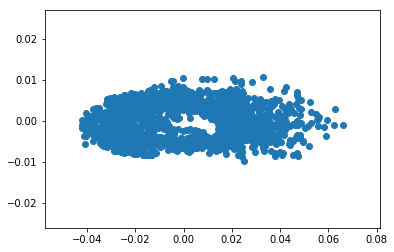

In [38]:
plt.scatter(diff_map_adaptive_1[:, 0], diff_map_adaptive_1[:, 1])
plt.savefig("figures/3.5.1_firstSecondComponents.png")

##### Plot second and third coordinates

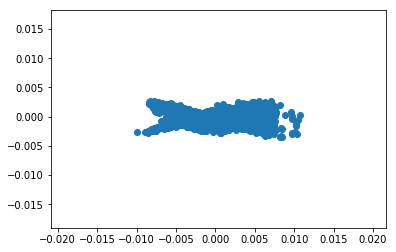

In [39]:
plt.scatter(diff_map_adaptive_1[:, 1], diff_map_adaptive_1[:, 2])
plt.savefig("figures/3.5.1_secondThirdComponents.png")

##### Plot third and fourth coordinates

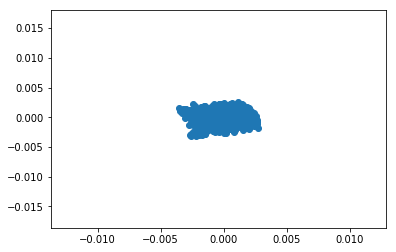

In [40]:
plt.scatter(diff_map_adaptive_1[:, 2], diff_map_adaptive_1[:, 3])
plt.savefig("figures/3.5.1_thirdFourthComponents.png")

#### Plot the eigenvalues of the Markov matrix M

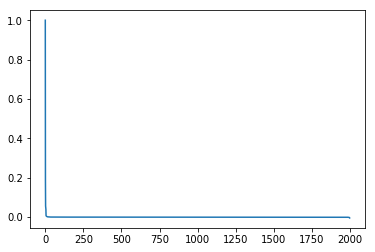

In [41]:
# Plot the eigenvalues of the Markov matrix M
plt.plot(diff_eig_adaptive_1)
plt.savefig("figures/3.5.1_eigenvaluesMarkov.png")

### Repeat for k = 10

In [42]:
# Repeat for k = 10

# create affinity matrix
W_adaptive_2 = ps1.compute_affinity_matrix(D, "adaptive", None ,10)

# Get eigenvectors and eigenvalues for diffusion map
diff_vec_adaptive_2, diff_eig_adaptive_2 = ps1.diff_map_info(W_adaptive_2)

# Get diffusion map
diff_map_adaptive_2 = ps1.get_diff_map(diff_vec_adaptive_2, diff_eig_adaptive_2, 1)

#### Create 2-D plots of the diffusion mapping

##### Plot first and second coordinates

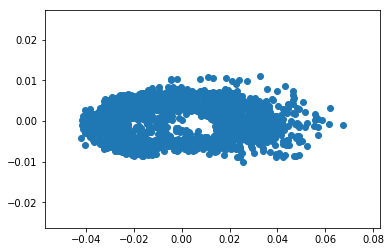

In [43]:
plt.scatter(diff_map_adaptive_2[:, 0], diff_map_adaptive_2[:, 1])
plt.savefig("figures/3.5.2_firstSecondComponents.png")

##### Plot second and third coordinates

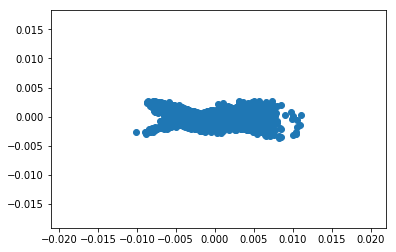

In [44]:
plt.scatter(diff_map_adaptive_2[:, 1], diff_map_adaptive_2[:, 2])
plt.savefig("figures/3.5.2_secondThirdComponents.png")

##### Plot third and fourth coordinates

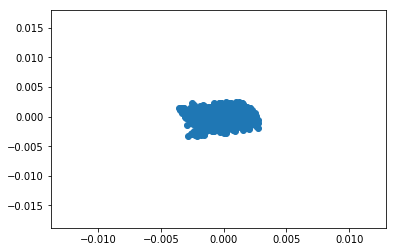

In [45]:
plt.scatter(diff_map_adaptive_2[:, 2], diff_map_adaptive_2[:, 3])
plt.savefig("figures/3.5.2_thirdFourthComponents.png")

#### Plot the eigenvalues of the Markov matrix M

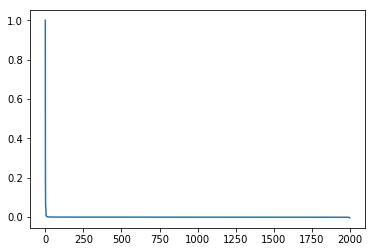

In [46]:
# Plot the eigenvalues of the Markov matrix M
plt.plot(diff_eig_adaptive_2)
plt.savefig("figures/3.5.2_eigenvaluesMarkov.png")

## Question 3.5.1. 

What are the differences between fixed and adaptive choices of kernel parameters σ? Explain this difference. What can you learn about the intrinsic dimensionality of the data set from the eigenvalues of M? How does the choice of nearest neighbor parameter k change the diffusion map? Which kernel method would you recommend using for the swiss roll data set and why?

### Answer:

Fixed choices of sigma enforces a homogeneous neighborhood size for the entire manifold. However, the density of the points may be highly variable, and having a fixed sigma could lead to too large a bandwidth in some areas and too small a bandwidth in other areas, hence the need for an adaptive choice of sigma. 

From the eigenvalues of M, we can tell how many (nonlinear) dimensions are required to describe the manifold of M, which gives us the intrinsic dimensionality. The eigenvalues for which the values are close to zero are not required for describing the manifold of M, so by looking at the eigenvalues which are well above 0, we can see how many dimensions are required and thus uncover M's intrinsic dimensionality. 

For the swiss roll dataset, I would recommend using the Gaussian kernel, rather than the adaptive kernel, because when the observations are translated to the diffusion mappings, it's clear that they map to more linear-like axes (which indicates that the diffusion mapping captures the "direction" of the manifold). In contrast, there is still heavy clustering when the adaptive kernel is used, which indicates that even after unfolding the manifold, the adaptive kernel doesn't capture the true direction of the manifold. 




# 3.6 Changing the Diffusion Parameter t

So far, we have kept the diffusion parameter set to t = 1. In this portion of Experiment 1, we will observe the effects of changing t. Note that for observing different t, you can re-use the affinity matrix and eigendecomposition computations. To this end, your tasks are
1. Construct the diffusion map Ψt of the swiss roll data set using euclidean distance, adaptive k-nearest neighbor Gaussian kernel with k = 10, and diffusion parameter t = 1.
2. Create two-dimensional scatter plots of the diffusion mapping using different coordinates.
3. Plot the eigenvalues λi of the Markov matrix M
4. Repeatfort=10,20,50

In [47]:
#1. Construct the diffusion map Ψt of the swiss roll data set using euclidean distance, 
# adaptive k-nearest neighbor Gaussian kernel with k = 10, and diffusion parameter t = 1.


# create affinity matrix
#W_adaptive_2 = ps1.compute_affinity_matrix(D, "adaptive", None ,10)

# Get eigenvectors and eigenvalues for diffusion map
#diff_vec_adaptive_2, diff_eig_adaptive_2 = ps1.diff_map_info(W_adaptive_2)

# Get diffusion map
#diff_map_adaptive_2 = ps1.get_diff_map(diff_vec_adaptive_2, diff_eig_adaptive_2, 1)

#### Create two-dimensional scatter plots of the diffusion mapping using different coordinates

##### Plot first and second coordinates

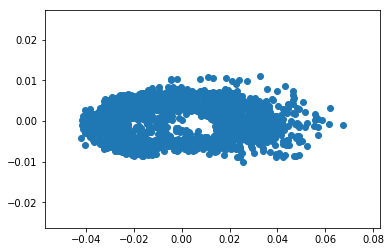

In [48]:
plt.scatter(diff_map_adaptive_2[:, 0], diff_map_adaptive_2[:, 1])
plt.savefig("figures/3.6.1_firstSecondComponents.png")

##### Plot second and third coordinates

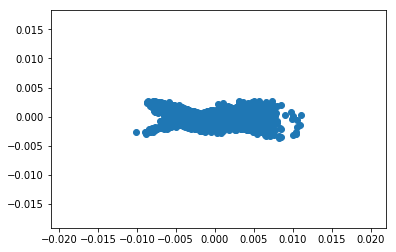

In [49]:
plt.scatter(diff_map_adaptive_2[:, 1], diff_map_adaptive_2[:, 2])
plt.savefig("figures/3.6.1_secondThirdComponents.png")

##### Plot third and fourth coordinates

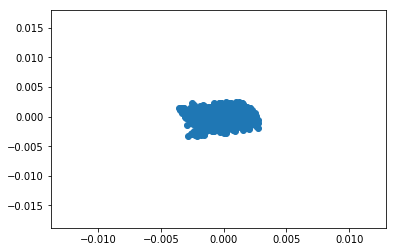

In [50]:
plt.scatter(diff_map_adaptive_2[:, 2], diff_map_adaptive_2[:, 3])
plt.savefig("figures/3.6.1_fourthFifthComponents.png")

#### Plot the eigenvalues of the Markov matrix M

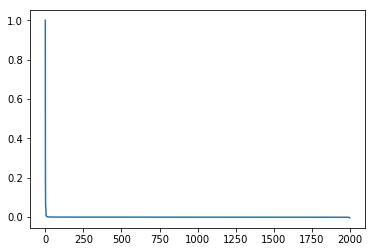

In [51]:
# Plot the eigenvalues of the Markov matrix M
plt.plot(diff_eig_adaptive_2)
plt.savefig("figures/3.6.1_eigenvaluesMarkov.png")

### Repeat for t = 10

In [52]:
# Get diffusion map
diff_map_adaptive_3 = ps1.get_diff_map(diff_vec_adaptive_2, diff_eig_adaptive_2, 10)

#### Create two-dimensional scatter plots of the diffusion mapping using different coordinates

##### Plot first and second coordinates

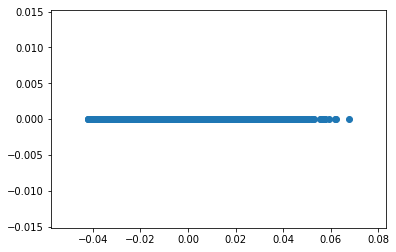

In [53]:
plt.scatter(diff_map_adaptive_3[:, 0], diff_map_adaptive_3[:, 1])
plt.savefig("figures/3.6.2_firstSecondComponents.png")

##### Plot second and third coordinates

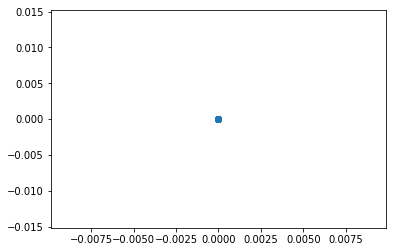

In [54]:
plt.scatter(diff_map_adaptive_3[:, 1], diff_map_adaptive_3[:, 2])
plt.savefig("figures/3.6.2_secondThirdComponents.png")

##### Plot third and fourth coordinates

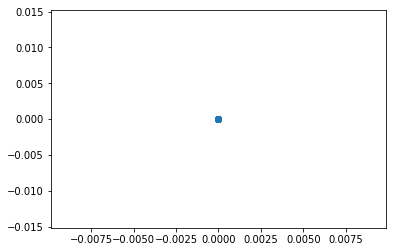

In [55]:
plt.scatter(diff_map_adaptive_3[:, 2], diff_map_adaptive_3[:, 3])
plt.savefig("figures/3.6.2_fourthFifthComponents.png")

#### Plot the eigenvalues of the Markov matrix M

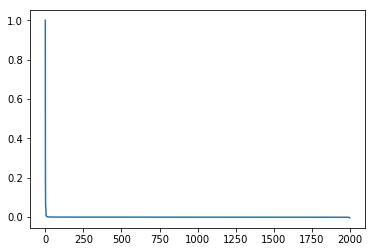

In [56]:
# Plot the eigenvalues of the Markov matrix M
plt.plot(diff_eig_adaptive_2)
plt.savefig("figures/3.6.2_eigenvaluesMarkov.png")

### Repeat for t = 20

In [57]:
# Get diffusion map
diff_map_adaptive_4 = ps1.get_diff_map(diff_vec_adaptive_2, diff_eig_adaptive_2, 20)

#### Create two-dimensional scatter plots of the diffusion mapping using different coordinates

##### Plot first and second coordinates

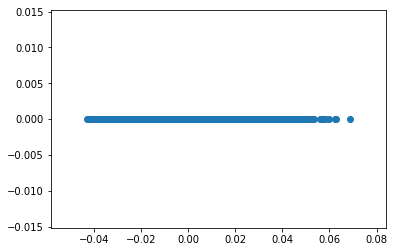

In [58]:
plt.scatter(diff_map_adaptive_4[:, 0], diff_map_adaptive_4[:, 1])
plt.savefig("figures/3.6.3_firstSecondComponents.png")

##### Plot second and third coordinates

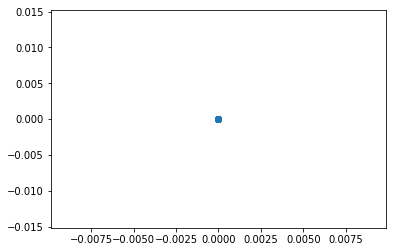

In [59]:
plt.scatter(diff_map_adaptive_4[:, 1], diff_map_adaptive_4[:, 2])
plt.savefig("figures/3.6.3_secondThirdComponents.png")

##### Plot third and fourth coordinates

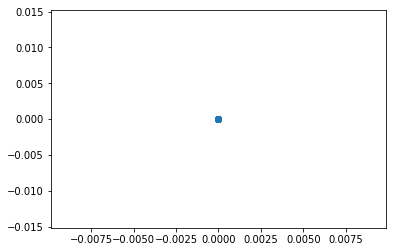

In [60]:
plt.scatter(diff_map_adaptive_4[:, 2], diff_map_adaptive_4[:, 3])
plt.savefig("figures/3.6.3_fourthFifthComponents.png")

#### Plot the eigenvalues of the Markov matrix M

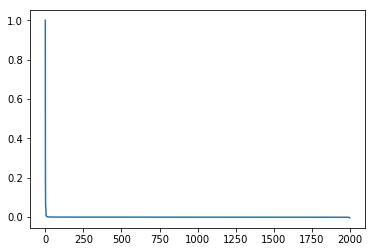

In [61]:
# Plot the eigenvalues of the Markov matrix M
plt.plot(diff_eig_adaptive_2)
plt.savefig("figures/3.6.3_eigenvaluesMarkov.png")

#### Repeat for t = 50

In [62]:
# Get diffusion map
diff_map_adaptive_5 = ps1.get_diff_map(diff_vec_adaptive_2, diff_eig_adaptive_2, 50)

#### Create two-dimensional scatter plots of the diffusion mapping using different coordinates

##### Plot first and second coordinates

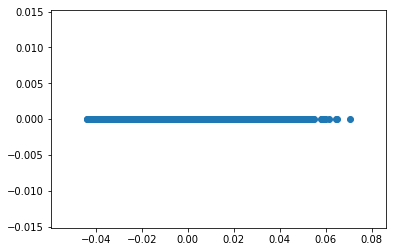

In [63]:
plt.scatter(diff_map_adaptive_5[:, 0], diff_map_adaptive_5[:, 1])
plt.savefig("figures/3.6.4_firstSecondComponents.png")

##### Plot second and third coordinates

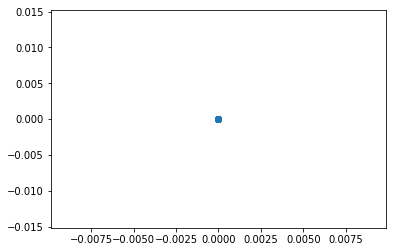

In [64]:
plt.scatter(diff_map_adaptive_5[:, 1], diff_map_adaptive_5[:, 2])
plt.savefig("figures/3.6.4_secondThirdComponents.png")

##### Plot third and fourth coordinates

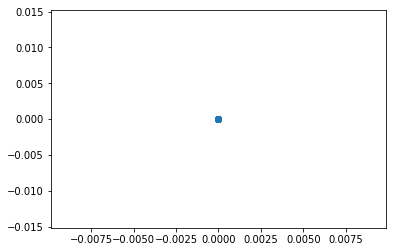

In [65]:
plt.scatter(diff_map_adaptive_5[:, 2], diff_map_adaptive_5[:, 3])
plt.savefig("figures/3.6.4_fourthFifthComponents.png")

#### Plot the eigenvalues of the Markov matrix M

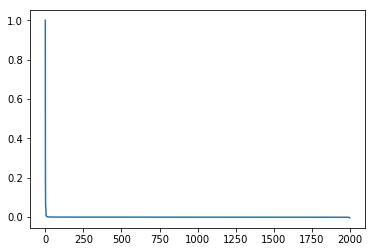

In [66]:
# Plot the eigenvalues of the Markov matrix M
plt.plot(diff_eig_adaptive_2)
plt.savefig("figures/3.6.4_eigenvaluesMarkov.png")

## Question 3.6.1. 

In terms of diffusion processes, what is the interpretation of increasing t? How do the diffusion embeddings visually change as t increases? How do the eigenvalues change and how does this help explain what you see in the embeddings? What can you learn about the intrinsic dimensionality of the data set from the eigenvalues of M as t increases? Is there a specific value of t that you find most informative for the Swiss roll data set?

### CHECK PIAZZA AS WELL FOR ANSWERS!

### Answer

In terms of diffusion, increasing t is equivalent to taking longer random walks or increasing the number of steps in the diffusion process. As t increases, the eigenvalues become smaller, with eigenvalues that were originally small being driven to zero much faster than eigenvalues that were large. As t increases, the embeddings lead to a more restrictive mapping of the original observations. Different observations in the original dataset were mapped more closely together in the embeddings, since a larger t means that there is likely a smaller possible subset of outcomes, since at points of concentrated outcomes more random walks will end up in the concentrated area, while for points that are far away from other points, fewer random walks will end up at those points. From the eigenvalues of M as t increases, we can see the number of embeddings necessary to express the new mapping of the diffusion process in t time steps. As t increases, we see the number of "necessary" eigenvalues (those that are significantly nonzero), and these indicate the "intrinsic dimensionality" of the dataset. It seems like a lower t is most informative for the Swiss roll dataset. It seems like at t = 1, there is still space for the diffusion mappings to be improved (in the sense that less clustering occurs, which would indicate that the function better captures the directionality of the manifold), but at t = 10 it seems like diffusion mappings are too specific (i.e., too many of the "unlikely" outcomes seem to be filtered out in favor of the very likely outcomes, so we only see the mappings for the most likely outcomes. This causes us to lose information about the "less likely" outcomes). Therefore, I would imagine that a t value between 1 and 10 would be most information for the Swiss roll dataset.



# 3.7 Final Thoughts
That’s all of the computation we need for understanding these methods on synthetic data. Fortunately, you should be able to use all the code you’ve written for this experiment for the next experiment with real data. Before doing that, let’s reflect on the data science aspect of our tests.

## Question 3.7.1. 

Suppose your boss is very delighted by your implementation of diffusion mappings and the initial tests on the swiss roll dataset; however, she would like to see how the method works on other artificial “control” data sets. Describe two other data sets that you might generate and what you would expect to see from these tests. You do not need to construct these two data sets.

### Answer

One dataset that I would produce is a dataset that is sinusoidal in some direction. In a vein similar to the swiss roll set, I would be interested in demonstrating how the diffusion mapping method affects a sinusoidal dataset. I would expect an implementation of the diffusion mapping to provide eigenvectors that track the sinusoidal direction of the dataset, and this would contrast with the PCA which, like in the swiss roll example, would only be able to track the linear directions and thus not capture the sinusoidal tendencies. 

Another dataset that I would produce is a dataset that is clustered in some higher-dimensional space, but linear in a lower-dimensional space. A simple example of this would be a dataset where the Xs and Ys are the same across clusters, but the Zs are either +1 or -1. In a higher-dimensional space, these data points are clustered, but in a lower-dimensional space they appear to occur in a line. I would expect that a diffusion mapping with an adaptive Gaussian kernel could capture this clustering effect since the adaptive kernel allows the algorithm to adapt to local clustering of points. 

# 4 Experiment 2: iPSC Reprogramming Dataset

This is a mass cytometry dataset taken from [3] that shows cellular reprogramming from mouse embryonic fibroblasts (MEFs) to induced pluripotent stem cells (iPSCs) via the introduction of a transcription factor known as Oct4. This data set measures 33 proteins at the single-cell resolution. The protein markers measure
1. pluripotency or stem-ness, e.g. sox4 oct4
2. differentiation: e.g. nanog and lin28 which are embryonic stem cell (ESC) markers
3. cell-cycle: e.g. pRB which is a cell proliferation marker
4. signaling status: e.g. pakt which is a growth inducing signal and p53 which signals DNA damage and could induce cell cycle arrest. The “p” preceding some of these markers indicates that the measurement is for the phosphorylated (usually active) conformation of the protein
5. apoptosis: e.g. ccasp3 which is a caspase marker involved in programmed cell death


Additionally a “timepoint” marker shows the day after stimulation with reprogramming factors that the measurement was taken from. Here you have a mix of timepoints. These are low-granularity time points (on the order of days), while the actual transition is much finer grained. These protein markers enable the measurement of the reprogramming status. For instance, a subset of cells shows evidence of being early reprogramming intermediates with the “correct” set of reprogramming factors Sox2+Oct4+Klf4+Nanog+, another subset seems successfully reprogrammed with ESC-like lineages expressing markers such as Nanog, Oct4, Lin28 and Ssea1, and Epcam that are associated with transition to pluripotency.As before, use the provided read json files() for reading the data set ipsc data set.json and the channel names channel names.json. The original data set contained observed 220,450 time points; however, for computational purposes, we have subsampled the data set to contain 2,000 time points. The timepoint of data point is simply its row number. So the first timepoint is row one, the second timepoint is row two, and so on. A variety of other pre-processing steps have already been done for you.

# 4.1 Visualizing Data with PCA

Let’s first explore how PCA can help us understand the processed data set. Your tasks for implementing PCA here are

1. Run PCA on the processed iPSC data set, obtaining the principal components, projections, and singular values.
2. Plot the iPSC data set in two dimensions, using the principal components. You might wish to try a few combinations of the top k = 5 principal components. When plotting the projections, color them using the time steps.
3. Plot the singular values in whatever way you see fit.

In [67]:
# import data
cellData = ps1.load_json_files("data/ipsc_data.json")
channelNames = ps1.load_json_files("data/ipsc_channel_names.json")

In [68]:
# preprocess the data by centering it
cellData_centered = cellData - np.mean(cellData)

In [69]:
# get timepoints
timePoints = np.arange(len(cellData_centered))

#### Create a function to calculate the correlation between a diffusion/principal component and the dataset

In [ ]:
# find the channels with the highest absolute correlation to the first diffusion component

def correl(data, diffusion_map):
    
    # store correlations
    cor = np.array([])

    # loop through, calculate correlations
    for channel in np.transpose(data):

        # calculate the pearson coefficient
        r = scipy.stats.pearsonr(channel, diffusion_map)

        # get absolute correlation (output of r is both pearson coeffient and the p-value)
        correlation = np.absolute(r[0])

        # append to correlations
        cor = np.append(cor, correlation)
        
    return cor

### 1. Run PCA on the processed iPSC data set, obtaining the principal components, projections, and singular values.

In [70]:
principalComponents_2, projection_2, singularValues_2 = calculatePCA(cellData_centered)

### 2. Plot the iPSC data set in two dimensions, using the principal components. You might wish to try a few combinations of the top k = 5 principal components. When plotting the projections, color them using the time steps.

##### For the first and second components

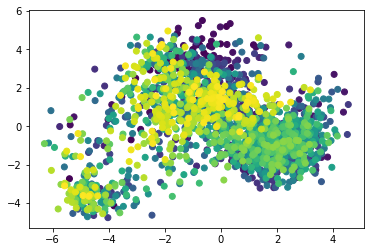

In [71]:
# First and second components:
plt.scatter(x = projection_2[:, 0], y = projection_2[:, 1], c = timePoints)
plt.savefig("figures/4.1_firstSecondComponents.png")

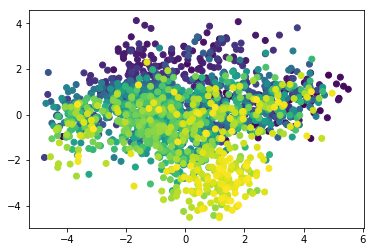

In [72]:
# Second and third components:
plt.scatter(x = projection_2[:, 1], y = projection_2[:, 2], c = timePoints)
plt.savefig("figures/4.1_secondThirdComponents.png")

##### For the third and fourth components

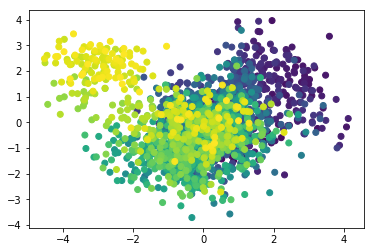

In [73]:
# Third and fourth components:
plt.scatter(x = projection_2[:, 2], y = projection_2[:, 3], c = timePoints)
plt.savefig("figures/4.1_thirdFourthComponents.png")

##### For the fourth and fifth components

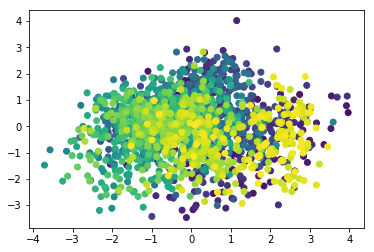

In [74]:
# Fourth and fifth components:
plt.scatter(x = projection_2[:, 3], y = projection_2[:, 4], c = timePoints)
plt.savefig("figures/4.1_fourthFifthComponents.png")

### 3. Plot the singular values in whatever way you see fit.

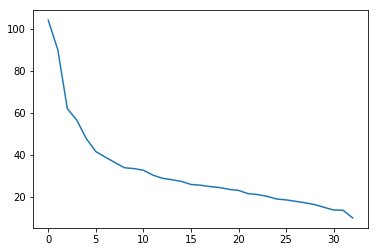

In [75]:
plt.plot(singularValues_2)
plt.savefig("figures/4.1_singularValues.png")

## Question 4.1.1. 

How do the PCA visualizations look? Are they capturing the time progression of the data set? Do you see any clusters forming? What is the intrinsic dimensionality given by PCA? What are the top few channels in the first and second principal directions?

#### Looking at the first principal direction

In [140]:
# get correlation
cor_0_1 = correl(cellData_centered, projection_2[:, 0])

In [141]:
# get the top 5 correlations, by index
ind_0_1 = np.argpartition(cor_0_1, -5)[-5:]

# get names of channels

top5Channels_0_1 = []

for index in ind_0_1:
    top5Channels_0_1.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the first component are: ", top5Channels_0_1)

The top 5 channels in correlation with the first component are:  ['c-myc', 'oct4', 'h3k9ac', 'ki67', 'prb']


#### Looking at the second principal direction

In [142]:
# get correlation
cor_0_2 = correl(cellData_centered, projection_2[:, 1])

In [143]:
# get the top 5 correlations, by index
ind_0_2 = np.argpartition(cor_0_2, -5)[-5:]

# get names of channels

top5Channels_0_2 = []

for index in ind_0_2:
    top5Channels_0_2.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the first component are: ", top5Channels_0_2)

The top 5 channels in correlation with the first component are:  ['ps6', 'pakt', 'pstat3-727', 'ikba', 'bcatenin']


### Answer:

When we look at the visualizations, we see clear clusters, which indicates that to a degree the time progression is captured by PCA. From the PCA, it seems like 3 dimensions would be sufficient to separate out the clusters (e.g., by looking at the first two principal components, it seems like creating a third plane would be sufficient for separating the clusters), so the intrinsic dimensionality would be 3. 

For the first principal direction, the top few channels are 'c-myc', 'oct4', 'h3k9ac', 'ki67', and 'prb'
For the second principal direction, the top few channels are 'ps6', 'pakt', 'pstat3-727', 'ikba', and 'bcatenin'

# 4.2 Visualizing Data with Diffusion Maps

Now let’s do a similar analysis using Diffusion Maps and see what changes. Here, your task will be to
1. Construct the affinity matrix of the iPSC data set using euclidean distance and adaptive k-nearest neighbors Gaussian kernel with k = 2 and diffusion parameter t = 1.
2. Create two-dimensional scatter plots of the diffusion mapping using different coordinates.
3. Create three-dimensional scatter plot of the diffusion mapping using the first three coordinates for plotting. Color the points with their corresponding timepoint values.
4. Plot the associated eigenvalues of the Markov matrix.
5. Compute the top 5 channels that have the highest absolute correlation with the first, second, and third diffusion components.

### 1. Construct the affinity matrix of the iPSC data set using euclidean distance and adaptive k-nearest neighbors Gaussian kernel with k = 2 and diffusion parameter t = 1.

In [76]:
# Get distance matrix
D_iPSC = ps1.compute_distances(cellData_centered)

In [77]:
# create affinity matrix
W_adaptive_iPSC = ps1.compute_affinity_matrix(D_iPSC, "adaptive", None ,2)

In [78]:
# Get eigenvectors and eigenvalues for diffusion map
diff_vec_adaptive_iPSC, diff_eig_adaptive_iPSC = ps1.diff_map_info(W_adaptive_iPSC)

In [79]:
# Get diffusion map
diff_map_adaptive_iPSC = ps1.get_diff_map(diff_vec_adaptive_iPSC, diff_eig_adaptive_iPSC, 1)

### 2. Create two-dimensional scatter plots of the diffusion mapping using different coordinates.

##### Mapping the first and second eigenvectors

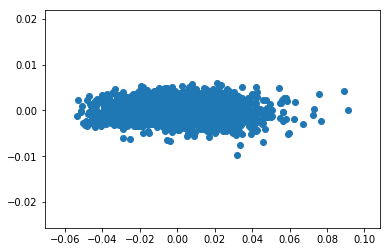

In [80]:
plt.scatter(diff_map_adaptive_iPSC[:, 0], diff_map_adaptive_iPSC[:, 1])
plt.savefig("figures/4.2_firstSecondComponents.png")

##### Mapping the second and third eigenvectors

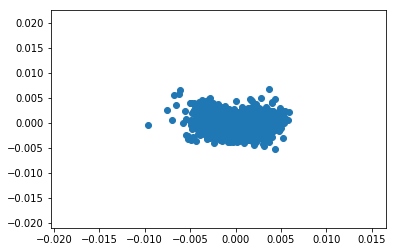

In [81]:
plt.scatter(diff_map_adaptive_iPSC[:, 1], diff_map_adaptive_iPSC[:, 2])
plt.savefig("figures/4.2_secondThirdComponents.png")

##### Mapping the third and fourth eigenvectors

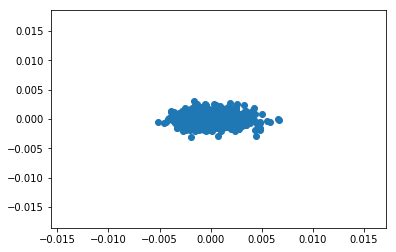

In [82]:
plt.scatter(diff_map_adaptive_iPSC[:, 2], diff_map_adaptive_iPSC[:, 3])
plt.savefig("figures/4.2_thirdFourthComponents.png")

### 3. Create three-dimensional scatter plot of the diffusion mapping using the first three coordinates for plotting. Color the points with their corresponding timepoint values.

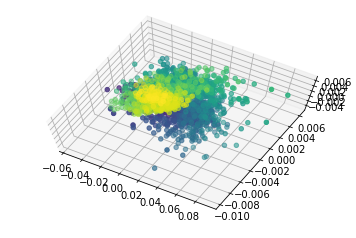

In [83]:
from mpl_toolkits.mplot3d import Axes3D

# plot the 3-d scatter plot

x_cell = diff_map_adaptive_iPSC[:, 0]
y_cell = diff_map_adaptive_iPSC[:, 1]
z_cell = diff_map_adaptive_iPSC[:, 2]

# 3-D spiral graph in matplotlib
fig_cell = plt.figure()
ax_cell = fig_cell.add_subplot(111, projection = '3d')
ax_cell.scatter(x_cell, y_cell, z_cell, c = timePoints)
ax_cell.view_init(elev = 75)
plt.savefig("figures/4.2_3_D_Scatter.png")

### 4. Plot the associated eigenvalues of the Markov matrix.

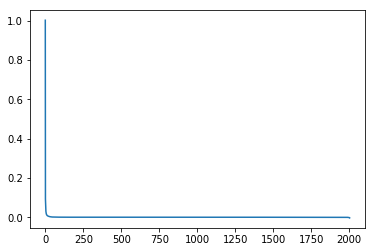

In [84]:
plt.plot(diff_eig_adaptive_iPSC)
plt.savefig("figures/4.2_eigenvaluesMarkov.png")

### 5. Compute the top 5 channels that have the highest absolute correlation with the first, second, and third diffusion components.

### Create a function to get the highest absolute correlation

In [85]:
# find the channels with the highest absolute correlation to the first diffusion component

#def correl(data, diffusion_map):
    
    # store correlations
#    cor = np.array([])

    # loop through, calculate correlations
#    for channel in np.transpose(data):

        # calculate the pearson coefficient
#        r = scipy.stats.pearsonr(channel, diffusion_map)

        # get absolute correlation (output of r is both pearson coeffient and the p-value)
#        correlation = np.absolute(r[0])

        # append to correlations
#        cor = np.append(cor, correlation)
        
#    return cor

#### Get top 5 channels that have the highest absolute correlation with the first diffusion component

In [86]:
# get correlations
cor_1_1 = correl(cellData_centered, diff_vec_adaptive_iPSC[:, 0])

In [87]:
# get the top 5 correlations, by index
ind_1_1 = np.argpartition(cor_1_1, -5)[-5:]

# get names of channels

top5Channels_1_1 = []

for index in ind_1_1:
    top5Channels_1_1.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the first component are: ", top5Channels_1_1)

The top 5 channels in correlation with the first component are:  ['sox2', 'ssea1', 'epcam', 'c-myc', 'p53']


#### Get top 5 channels that have the highest absolute correlation with the second diffusion component

In [88]:
# get correlations
cor_1_2 = correl(cellData_centered, diff_vec_adaptive_iPSC[:, 1])

In [89]:
# get the top 5 correlations, by index
ind_1_2 = np.argpartition(cor_1_2, -5)[-5:]

# get names of channels

top5Channels_1_2 = []

for index in ind_1_2:
    top5Channels_1_2.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the second component are: ", top5Channels_1_2)

The top 5 channels in correlation with the second component are:  ['pampk', 'cd73', 'oct4', 'klf4', 'sox2']


#### Get top 5 channels that have the highest absolute correlation with the third diffusion component

In [90]:
# get correlations
cor_1_3 = correl(cellData_centered, diff_vec_adaptive_iPSC[:, 2])

In [91]:
# get the top 5 correlations, by index
ind_1_3 = np.argpartition(cor_1_3, -5)[-5:]

# get names of channels

top5Channels_1_3 = []

for index in ind_1_3:
    top5Channels_1_3.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the third component are: ", top5Channels_1_3)

The top 5 channels in correlation with the third component are:  ['pakt', 'ps6', 'c-myc', 'thy1', 'sox2']


## Question 4.2.1. 

How do the Diffusion Map visualizations look? Are they capturing the time progression of the data set? Do you see any clusters forming? What is the intrinsic dimensionality given by Diffusion Maps? Which channels are most highly correlated with diffusion components? Any guesses to the biological interpretation? What are the main differences between Diffusion Maps and PCA methods on the iPSC data set?

### Answer

By looking at the 3-d plot it seems like the time progression of the data set is captured (because clear colored clusters are seen, where the color corresponds to the time points). It seems like, based off the diffusion maps, that the intrinsic dimensionality is 3, since the 3-d plot seems sufficient to show the clear clusters. Certain channels seem to be correlated with multiple diffusion components, in particular 'sox2' (which is correlated with the first 3 diffusion components) and 'c-myc' (which is correlated with the first and third diffusion components). Biologically, it could be possible that these channels are essential to the processes that are being observed. On the iPSC dataset, it seems like diffusion maps "unfold" the manifold on which the iPSC dataset exist, leading to more "linear" mappings of the dataset onto the embeddings (therefore we don't see as much clustering when we create the 2-d plots), while the PCA method looks for linear trends in the original space that the dataset exists, so when you map the data onto the principal components the observations are still clearly clustered (so the underlying directionality hasn't been captured yet). 

# 4.3 Changing Parameters

In this section, we’ll examine how changing parameters affects the iPSC data set. Your tasks will be
1. Try two different values of diffusion parameter t and visualize the embeddings and the eigenvalues.
2. Try two different values of k for the adaptive kernel and visualize the embeddings and the eigenvalues.
3. For every choice of parameters above, compute the top 5 channels that have the highest absolute correlation with the first, second, and third diffusion components.

### 1. Try two different values of diffusion parameter t and visualize the embeddings and the eigenvalues.

##### For t = 5 (and k = 2)

#### Get diffusion map

In [92]:
# Get diffusion map
diff_map_adaptive_iPSC_2 = ps1.get_diff_map(diff_vec_adaptive_iPSC, diff_eig_adaptive_iPSC, 5)

#### Visualize the embeddings

##### For first and second embeddings

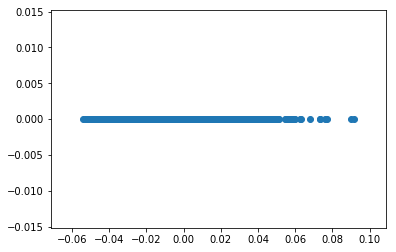

In [93]:
plt.scatter(x = diff_map_adaptive_iPSC_2[:, 0], y = diff_map_adaptive_iPSC_2[:, 1])
plt.savefig("figures/4.3.1_firstSecondComponents.png")

##### For second and third embeddings

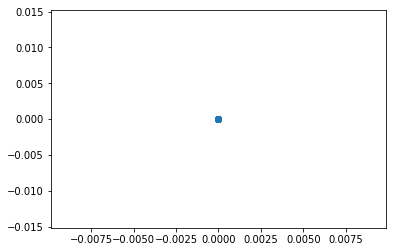

In [94]:
plt.scatter(x = diff_map_adaptive_iPSC_2[:, 1], y = diff_map_adaptive_iPSC_2[:, 2])
plt.savefig("figures/4.3.1_secondThirdComponents.png")

##### For third and fourth embeddings

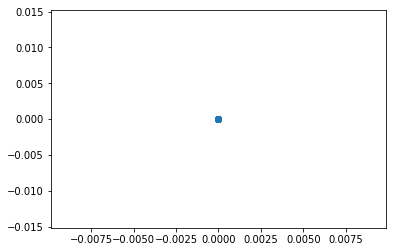

In [95]:
plt.scatter(x = diff_map_adaptive_iPSC_2[:, 2], y = diff_map_adaptive_iPSC_2[:, 3])
plt.savefig("figures/4.3.1_thirdFourthComponents.png")

#### Visualize the eigenvalues (for t = 5)

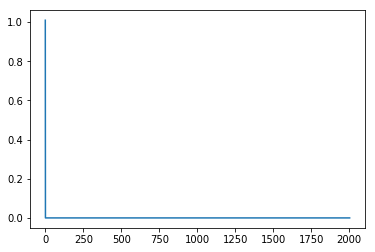

In [96]:
plt.plot(np.power(diff_eig_adaptive_iPSC, 5))
plt.savefig("figures/4.3.1_eigenvalues.png")

##### For t = 15 (and k = 2)

In [97]:
# Get diffusion map
diff_map_adaptive_iPSC_3 = ps1.get_diff_map(diff_vec_adaptive_iPSC, diff_eig_adaptive_iPSC, 15)

#### Visualize the embeddings

##### For first and second embeddings

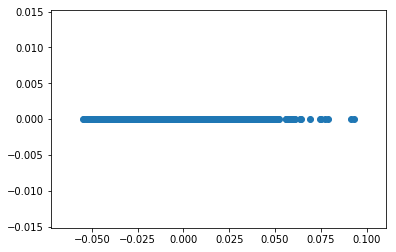

In [98]:
plt.scatter(x = diff_map_adaptive_iPSC_3[:, 0], y = diff_map_adaptive_iPSC_3[:, 1])
plt.savefig("figures/4.3.2_firstSecondComponents.png")

##### For second and third embeddings

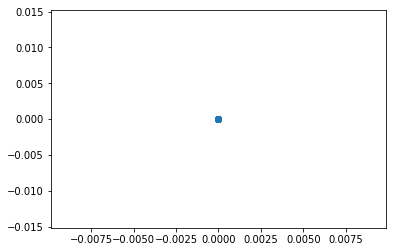

In [99]:
plt.scatter(x = diff_map_adaptive_iPSC_3[:, 1], y = diff_map_adaptive_iPSC_3[:, 2])
plt.savefig("figures/4.3.2_secondThirdComponents.png")

##### For third and fourth embeddings

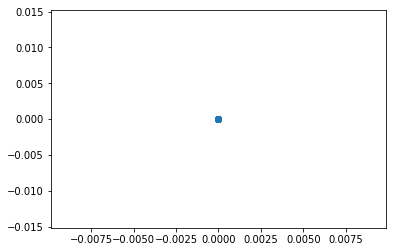

In [100]:
plt.scatter(x = diff_map_adaptive_iPSC_3[:, 2], y = diff_map_adaptive_iPSC_3[:, 3])
plt.savefig("figures/4.3.2_thirdFourthComponents.png")

#### Visualize the eigenvalues (for t = 15)

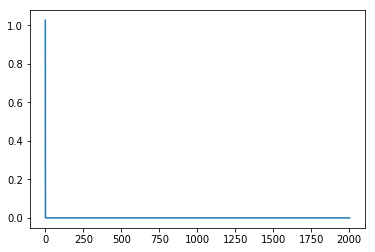

In [101]:
plt.plot(np.power(diff_eig_adaptive_iPSC, 15))
plt.savefig("figures/4.3.2_eigenvalues.png")

### 2. Try two different values of k for the adaptive kernel and visualize the embeddings and the eigenvalues.

##### For k = 5 (fixing t = 1)

#### Create affinity matrix

In [154]:
# create affinity matrix
W_adaptive_iPSC_k2 = ps1.compute_affinity_matrix(D_iPSC, "adaptive", None ,5)

#### Get eigenvectors and eigenvalues for diffusion map

In [155]:
# Get eigenvectors and eigenvalues for diffusion map
diff_vec_adaptive_iPSC_k2, diff_eig_adaptive_iPSC_k2 = ps1.diff_map_info(W_adaptive_iPSC_k2)

#### Get diffusion map

In [156]:
# Get diffusion map
diff_map_adaptive_iPSC_k2 = ps1.get_diff_map(diff_vec_adaptive_iPSC_k2, diff_eig_adaptive_iPSC_k2, 1)

#### Visualize the embeddings

##### For first and second embeddings

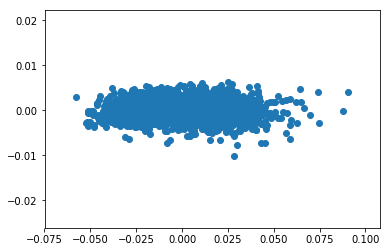

In [157]:
plt.scatter(x = diff_map_adaptive_iPSC_k2[:, 0], y = diff_map_adaptive_iPSC_k2[:, 1])
plt.savefig("figures/4.3.3_firstSecondComponents.png")

##### For second and third embeddings

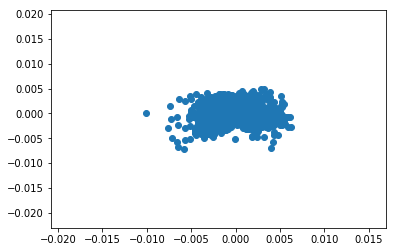

In [158]:
plt.scatter(x = diff_map_adaptive_iPSC_k2[:, 1], y = diff_map_adaptive_iPSC_k2[:, 2])
plt.savefig("figures/4.3.3_secondThirdComponents.png")

##### For third and fourth embeddings

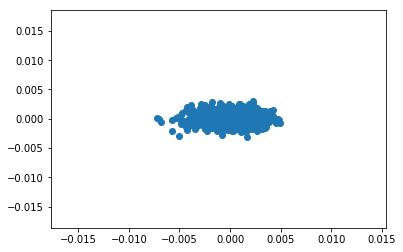

In [159]:
plt.scatter(x = diff_map_adaptive_iPSC_k2[:, 2], y = diff_map_adaptive_iPSC_k2[:, 3])
plt.savefig("figures/4.3.3_thirdFourthComponents.png")

#### Visualize the eigenvalues (for k = 5)

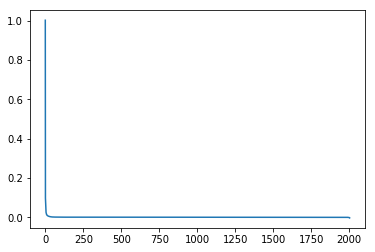

In [160]:
# visualize the embeddings
plt.plot(diff_eig_adaptive_iPSC_k2)
plt.savefig("figures/4.3.3_eigenvalues.png")

##### For k = 15 (fixing t = 1)

#### Create affinity matrix

In [161]:
# create affinity matrix
W_adaptive_iPSC_k3 = ps1.compute_affinity_matrix(D_iPSC, "adaptive", None ,15)

#### Get eigenvectors and eigenvalues for diffusion map

In [162]:
# Get eigenvectors and eigenvalues for diffusion map
diff_vec_adaptive_iPSC_k3, diff_eig_adaptive_iPSC_k3 = ps1.diff_map_info(W_adaptive_iPSC_k3)

#### Get diffusion map

In [163]:
# Get diffusion map
diff_map_adaptive_iPSC_k3 = ps1.get_diff_map(diff_vec_adaptive_iPSC_k3, diff_eig_adaptive_iPSC_k3, 1)

#### Visualize the embeddings

##### For first and second embeddings

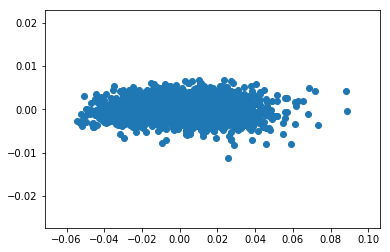

In [164]:
plt.scatter(x = diff_map_adaptive_iPSC_k3[:, 0], y = diff_map_adaptive_iPSC_k3[:, 1])
plt.savefig("figures/4.3.4_firstSecondComponents.png")

##### For second and third embeddings

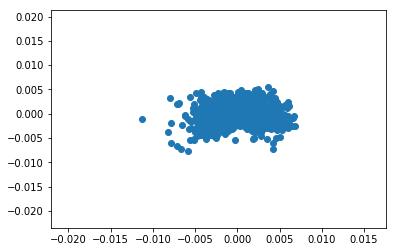

In [165]:
plt.scatter(x = diff_map_adaptive_iPSC_k3[:, 1], y = diff_map_adaptive_iPSC_k3[:, 2])
plt.savefig("figures/4.3.4_secondThirdComponents.png")

##### For third and fourth embeddings

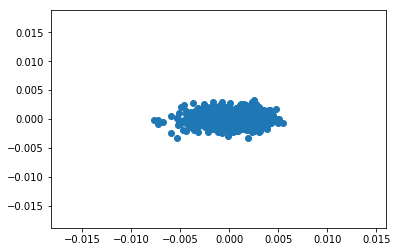

In [166]:
plt.scatter(x = diff_map_adaptive_iPSC_k3[:, 2], y = diff_map_adaptive_iPSC_k3[:, 3])
plt.savefig("figures/4.3.4_thirdFourthComponents.png")

#### Visualize the eigenvalues (for k = 15)

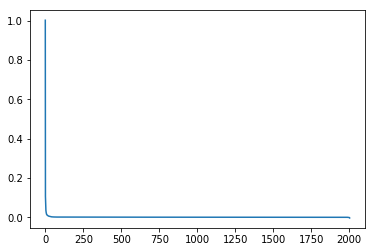

In [167]:
# visualize the embeddings
plt.plot(diff_eig_adaptive_iPSC_k3)
plt.savefig("figures/4.3.4_eigenvalues.png")

### 3. For every choice of parameters above, compute the top 5 channels that have the highest absolute correlation with the first, second, and third diffusion components.

#### For t = 5

##### Correlation with the first diffusion component

In [116]:
### Calculate correlation
correl_2_1 =  correl(cellData_centered, diff_map_adaptive_iPSC_2[:, 0])

In [117]:
# get the top 5 correlations, by index
ind_2_1 = np.argpartition(correl_2_1, -5)[-5:]

# get names of channels

top5Channels_2_1 = []

for index in ind_2_1:
    top5Channels_2_1.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the first component are: ", top5Channels_2_1)

The top 5 channels in correlation with the first component are:  ['sox2', 'ssea1', 'epcam', 'c-myc', 'p53']


##### Correlation with the second diffusion component

In [118]:
### Calculate correlation
correl_2_2 =  correl(cellData_centered, diff_map_adaptive_iPSC_2[:, 1])

In [119]:
# get the top 5 correlations, by index
ind_2_2 = np.argpartition(correl_2_2, -5)[-5:]

# get names of channels

top5Channels_2_2 = []

for index in ind_2_2:
    top5Channels_2_2.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the second component are: ", top5Channels_2_2)

The top 5 channels in correlation with the second component are:  ['pampk', 'cd73', 'oct4', 'klf4', 'sox2']


##### Correlation with the third diffusion component

In [120]:
### Calculate correlation
correl_2_3 =  correl(cellData_centered, diff_map_adaptive_iPSC_2[:, 2])

In [121]:
# get the top 5 correlations, by index
ind_2_3 = np.argpartition(correl_2_3, -5)[-5:]

# get names of channels

top5Channels_2_3 = []

for index in ind_2_3:
    top5Channels_2_3.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the third component are: ", top5Channels_2_3)

The top 5 channels in correlation with the third component are:  ['pakt', 'ps6', 'c-myc', 'thy1', 'sox2']


#### For t = 15

##### Correlation with the first diffusion component

In [122]:
### Calculate correlation
correl_3_1 =  correl(cellData_centered, diff_map_adaptive_iPSC_3[:, 0])

In [123]:
# get the top 5 correlations, by index
ind_3_1 = np.argpartition(correl_3_1, -5)[-5:]

# get names of channels

top5Channels_3_1 = []

for index in ind_3_1:
    top5Channels_3_1.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the first component are: ", top5Channels_3_1)

The top 5 channels in correlation with the first component are:  ['sox2', 'ssea1', 'epcam', 'c-myc', 'p53']


##### Correlation with the second diffusion component

In [124]:
### Calculate correlation
correl_3_2 =  correl(cellData_centered, diff_map_adaptive_iPSC_3[:, 1])

In [125]:
# get the top 5 correlations, by index
ind_3_2 = np.argpartition(correl_3_2, -5)[-5:]

# get names of channels

top5Channels_3_2 = []

for index in ind_3_2:
    top5Channels_3_2.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the second component are: ", top5Channels_3_2)

The top 5 channels in correlation with the second component are:  ['pampk', 'cd73', 'oct4', 'klf4', 'sox2']


##### Correlation with the third diffusion component

In [126]:
### Calculate correlation
correl_3_3 =  correl(cellData_centered, diff_map_adaptive_iPSC_3[:, 2])

In [127]:
# get the top 5 correlations, by index
ind_3_3 = np.argpartition(correl_3_3, -5)[-5:]

# get names of channels

top5Channels_3_3 = []

for index in ind_3_3:
    top5Channels_3_3.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the third component are: ", top5Channels_3_3)

The top 5 channels in correlation with the third component are:  ['pakt', 'ps6', 'c-myc', 'thy1', 'sox2']


#### For k = 5 (and t = 1)

##### Correlation with the first diffusion component

In [128]:
### Calculate correlation
correl_4_1 =  correl(cellData_centered, diff_map_adaptive_iPSC_k2[:, 0])

In [129]:
# get the top 5 correlations, by index
ind_4_1 = np.argpartition(correl_4_1, -5)[-5:]

# get names of channels

top5Channels_4_1 = []

for index in ind_4_1:
    top5Channels_4_1.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the first component are: ", top5Channels_4_1)

The top 5 channels in correlation with the first component are:  ['cd54', 'ssea1', 'epcam', 'p53', 'c-myc']


##### Correlation with the second diffusion component

In [130]:
### Calculate correlation
correl_4_2 =  correl(cellData_centered, diff_map_adaptive_iPSC_k2[:, 1])

In [131]:
# get the top 5 correlations, by index
ind_4_2 = np.argpartition(correl_4_2, -5)[-5:]

# get names of channels

top5Channels_4_2 = []

for index in ind_4_2:
    top5Channels_4_2.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the second component are: ", top5Channels_4_2)

The top 5 channels in correlation with the second component are:  ['pampk', 'oct4', 'sox2', 'klf4', 'cd73']


##### Correlation with the third diffusion component

In [132]:
### Calculate correlation
correl_4_3 =  correl(cellData_centered, diff_map_adaptive_iPSC_k2[:, 2])

In [133]:
# get the top 5 correlations, by index
ind_4_3 = np.argpartition(correl_4_3, -5)[-5:]

# get names of channels

top5Channels_4_3 = []

for index in ind_4_3:
    top5Channels_4_3.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the third component are: ", top5Channels_4_3)

The top 5 channels in correlation with the third component are:  ['pakt', 'ps6', 'thy1', 'c-myc', 'sox2']


#### For k = 15 (and t = 1)

##### Correlation with the first diffusion component

In [134]:
### Calculate correlation
correl_5_1 =  correl(cellData_centered, diff_map_adaptive_iPSC_k3[:, 0])

In [135]:
# get the top 5 correlations, by index
ind_5_1 = np.argpartition(correl_5_1, -5)[-5:]

# get names of channels

top5Channels_5_1 = []

for index in ind_5_1:
    top5Channels_5_1.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the first component are: ", top5Channels_5_1)

The top 5 channels in correlation with the first component are:  ['lin28', 'ssea1', 'epcam', 'p53', 'c-myc']


##### Correlation with the second diffusion component

In [136]:
### Calculate correlation
correl_5_2 =  correl(cellData_centered, diff_map_adaptive_iPSC_k3[:, 1])

In [137]:
# get the top 5 correlations, by index
ind_5_2 = np.argpartition(correl_5_2, -5)[-5:]

# get names of channels

top5Channels_5_2 = []

for index in ind_5_2:
    top5Channels_5_2.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the second component are: ", top5Channels_5_2)

The top 5 channels in correlation with the second component are:  ['pampk', 'oct4', 'cd73', 'klf4', 'sox2']


##### Correlation with the third diffusion component

In [138]:
### Calculate correlation
correl_5_3 =  correl(cellData_centered, diff_map_adaptive_iPSC_k3[:, 2])

In [139]:
# get the top 5 correlations, by index
ind_5_3 = np.argpartition(correl_5_3, -5)[-5:]

# get names of channels

top5Channels_5_3 = []

for index in ind_5_3:
    top5Channels_5_3.append(channelNames[index])
    
# print the names of the channels
print("The top 5 channels in correlation with the third component are: ", top5Channels_5_3)

The top 5 channels in correlation with the third component are:  ['pampk', 'ps6', 'c-myc', 'sox2', 'thy1']


## Question 4.3.1. 

Did the choice of t affect the embeddings and, if so, how? Do the corresponding eigenvalues support your findings? How did the choice of k affect the embeddings and, if so, how? Did previously observed trends (i.e. clusters, time progression) in diffusion dimensions change dramatically? Did the correlated channels change with σ? How would you interpret this in terms of the data?

### Answer:

The choice of t does affect the embeddings, since the choice of t drives certain eigenvalues closer to zero as t increases. This is evidenced by the eigenvalues, since we observe that at higher t values, the first eigenvalues stay more robust, while the later eigenvalues are driven to zero. As k increases, the embeddings capture more clustered behavior, so the projection of the data points on the embedding space appears more clustered as k increases. This would make sense, since considering a higher value of k would match any given point to a wider neighborhood of points. Previously observed trends changed slightly, butnot dramatically. As sigma increases, the correlated channels seem to mostly remain the same, with some changes. In terms of the data, this would mean that when you change the kernel width, certain "core" patterns are still being captured, and this is represented by the channels that still remain correlated with the mappings as signma changes. In the context of biology, these channels would likely represent the channels that are most likely to truly affect the parameters in question